## 1. Load the raw dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------
# 1. Load the raw dataset
# ------------------------------
# The CSV file has columns: timestamp, alarm, serial.
df = pd.read_csv('https://raw.githubusercontent.com/CasterShade/AIM-5001/refs/heads/main/alarms.csv', parse_dates=["timestamp"])
df.head()

,timestamp,alarm,serial
0,2019-02-21 19:57:57.532,139,4
1,2019-02-21 19:58:28.293,139,4
2,2019-02-21 19:58:32.853,139,4
3,2019-02-21 19:59:05.387,139,4
4,2019-02-21 20:02:05.832,139,4


Checking the data structure

In [2]:
print("DataFrame Info:")
print(df.info())

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 444834 entries, 0 to 444833
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   timestamp  444834 non-null  datetime64[ns]
 1   alarm      444834 non-null  int64         
 2   serial     444834 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 10.2 MB
None


In [3]:
print("\nSummary Statistics:")
print(df.describe())


Summary Statistics:
                           timestamp          alarm         serial
count                         444834  444834.000000  444834.000000
mean   2019-10-30 08:32:08.563483392      69.071004       7.657108
min       2019-02-21 10:16:18.130000       0.000000       0.000000
25%    2019-07-06 01:20:51.280249856      26.000000       4.000000
50%       2019-11-05 02:08:01.488000      45.000000       7.000000
75%    2020-02-25 15:07:32.806500096     119.000000      12.000000
max       2020-06-17 03:53:51.885000     153.000000      19.000000
std                              NaN      49.876903       4.594188


## 2. Basic Exploratory Data Analysis (EDA)

### Distribution of alarm codes

<ipython-input-4-d6f557068812>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=alarm_counts.index, y=alarm_counts.values, palette="viridis")


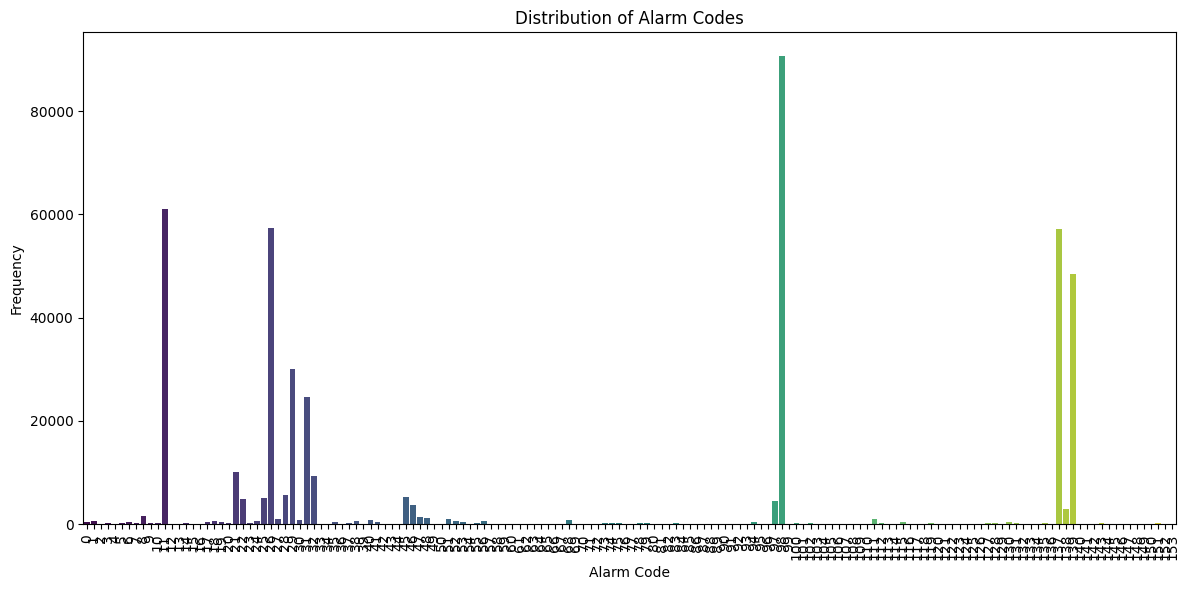

In [4]:
# ------------------------------
# 2. Basic Exploratory Data Analysis (EDA)
# ------------------------------

# Distribution of alarm codes
plt.figure(figsize=(12, 6))
alarm_counts = df['alarm'].value_counts().sort_index()
sns.barplot(x=alarm_counts.index, y=alarm_counts.values, palette="viridis")
plt.title("Distribution of Alarm Codes")
plt.xlabel("Alarm Code")
plt.ylabel("Frequency")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### Distribution of alarms per machine (serial)

<ipython-input-5-e3e94c233986>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=serial_counts.index, y=serial_counts.values, palette="magma")


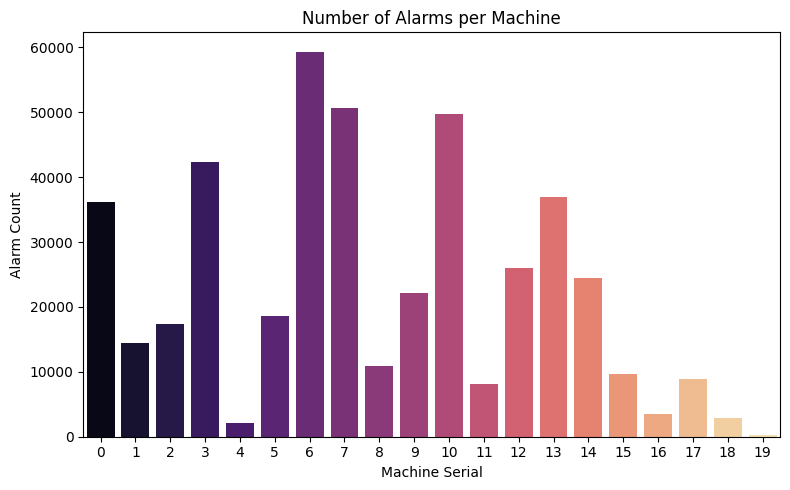

In [5]:
# Distribution of alarms per machine (serial)
plt.figure(figsize=(8, 5))
serial_counts = df['serial'].value_counts().sort_index()
sns.barplot(x=serial_counts.index, y=serial_counts.values, palette="magma")
plt.title("Number of Alarms per Machine")
plt.xlabel("Machine Serial")
plt.ylabel("Alarm Count")
plt.tight_layout()
plt.show()

### Time-series analysis: count alarms per day for a subset of alarms or machines

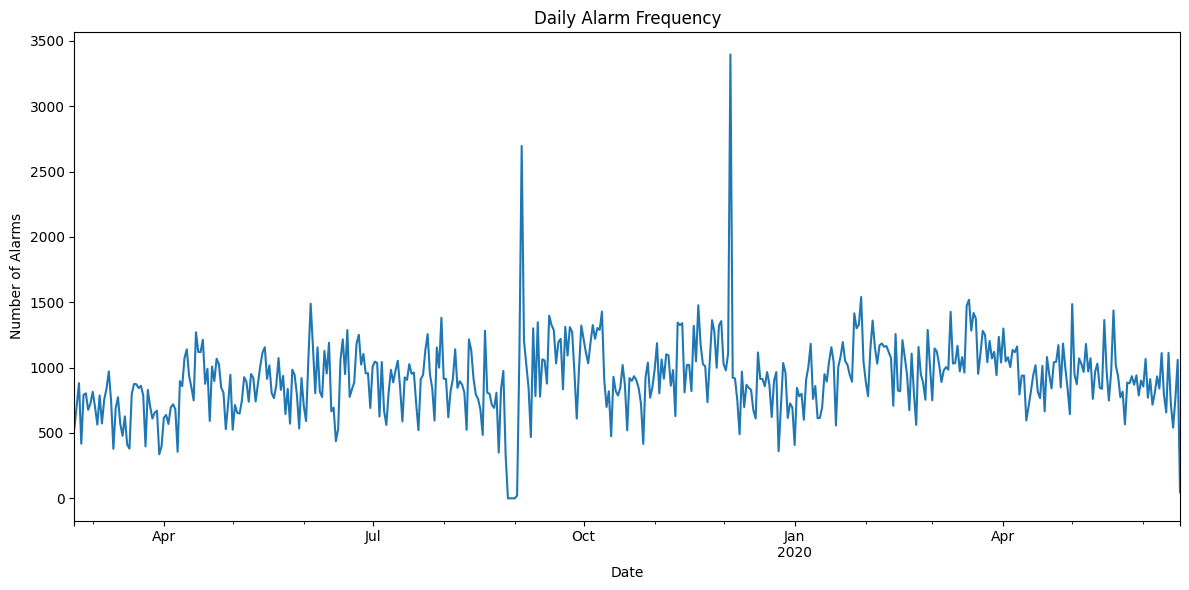

In [6]:
# Setting the timestamp as the DataFrame index for resampling
df_ts = df.set_index("timestamp")

# Resample to daily frequency and count alarms
daily_counts = df_ts.resample("D").size()
plt.figure(figsize=(12, 6))
daily_counts.plot()
plt.title("Daily Alarm Frequency")
plt.xlabel("Date")
plt.ylabel("Number of Alarms")
plt.tight_layout()
plt.show()

## 3. Preprocessing: Removing Consecutive Duplicate Alarms

In [7]:
# ------------------------------
# 3. Preprocessing: Removing Consecutive Duplicate Alarms
# ------------------------------
# In alarm logs, consecutive duplicate entries can be redundant.
# This function prunes consecutive duplicates from a list.
def prune_series(seq):
    # Retain the first alarm and any alarm that is different from its immediate predecessor
    pruned = [seq[0]] if seq else []
    for alarm in seq[1:]:
        if alarm != pruned[-1]:
            pruned.append(alarm)
    return pruned

# Apply the pruning on a per-machine basis
def prune_alarm_logs(df):
    # Sort the data by timestamp for each machine
    df_sorted = df.sort_values(["serial", "timestamp"])
    # Group by machine serial and remove consecutive duplicate alarms
    pruned_groups = []
    for serial, group in df_sorted.groupby("serial"):
        pruned_group = group.copy()
        # Create a flag to identify where the current alarm differs from the previous one
        pruned_group['prune_flag'] = pruned_group['alarm'] != pruned_group['alarm'].shift()
        pruned_group = pruned_group[pruned_group['prune_flag']]
        pruned_groups.append(pruned_group.drop(columns='prune_flag'))
    return pd.concat(pruned_groups)

In [8]:
df_pruned = prune_alarm_logs(df)
print("Original number of rows:", df.shape[0])
print("After pruning consecutive duplicates:", df_pruned.shape[0])

Original number of rows: 444834
After pruning consecutive duplicates: 125825


### Distribution of alarm codes

<ipython-input-9-1bf5c8337e3e>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=alarm_counts.index, y=alarm_counts.values, palette="viridis")


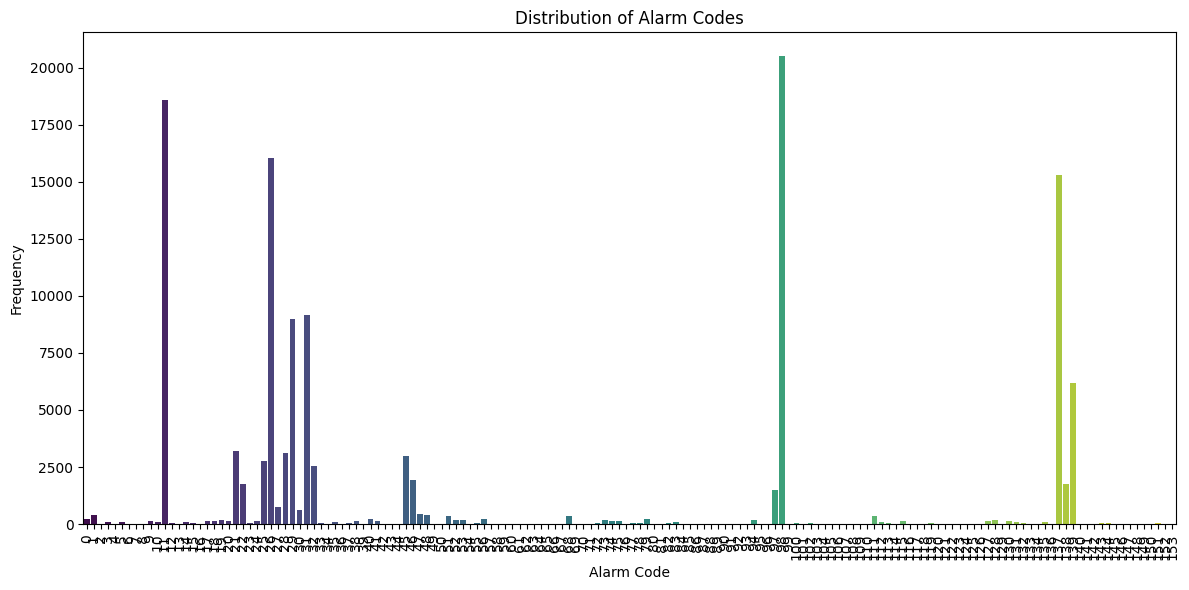

In [9]:
# Distribution of alarm codes
plt.figure(figsize=(12, 6))
alarm_counts = df_pruned['alarm'].value_counts().sort_index()
sns.barplot(x=alarm_counts.index, y=alarm_counts.values, palette="viridis")
plt.title("Distribution of Alarm Codes")
plt.xlabel("Alarm Code")
plt.ylabel("Frequency")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### Distribution of alarms per machine (serial)

<ipython-input-10-4c08e6788bb9>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=serial_counts.index, y=serial_counts.values, palette="magma")


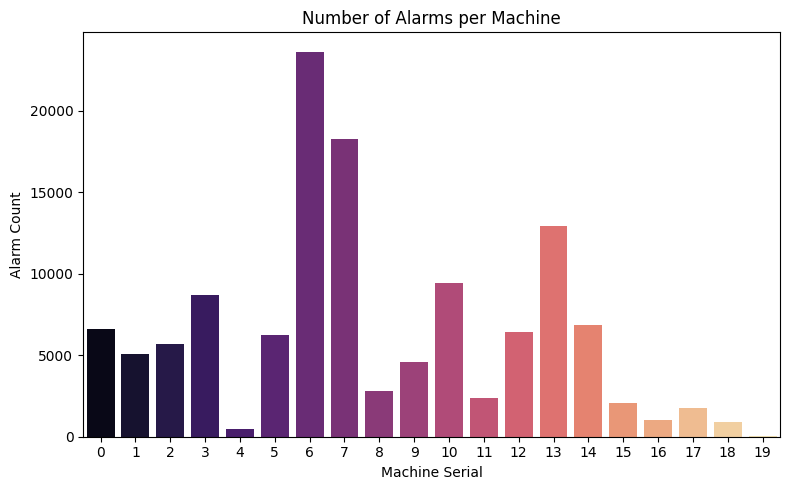

In [10]:
# Distribution of alarms per machine (serial)
plt.figure(figsize=(8, 5))
serial_counts = df_pruned['serial'].value_counts().sort_index()
sns.barplot(x=serial_counts.index, y=serial_counts.values, palette="magma")
plt.title("Number of Alarms per Machine")
plt.xlabel("Machine Serial")
plt.ylabel("Alarm Count")
plt.tight_layout()
plt.show()

### Time-series analysis: count alarms per day for a subset of alarms or machines

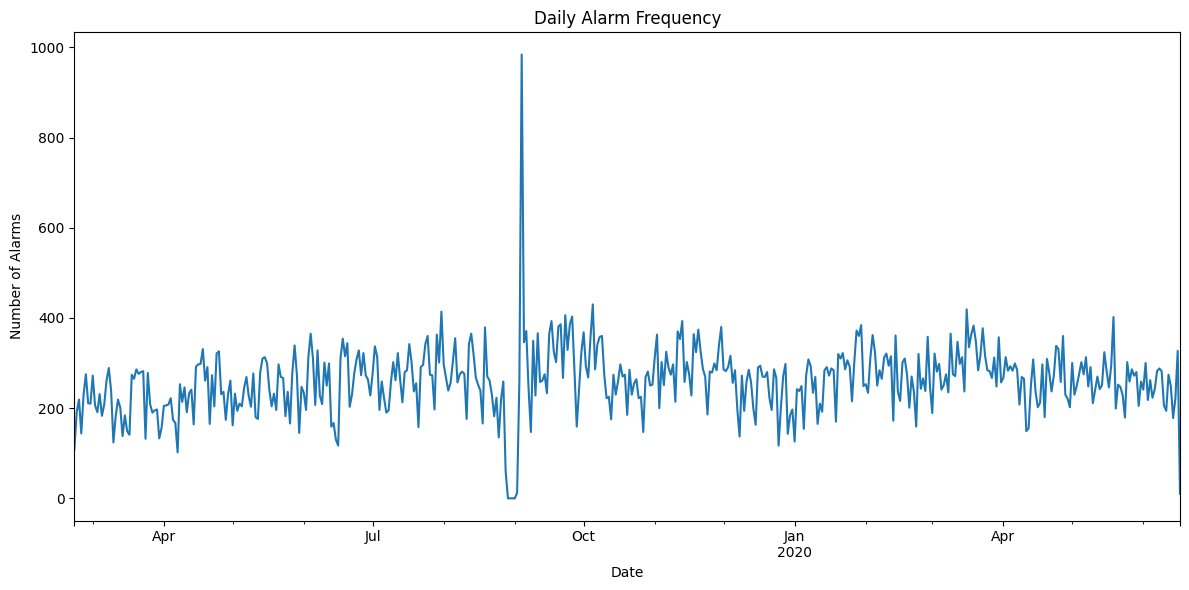

In [11]:
# Setting the timestamp as the DataFrame index for resampling
df_ts = df_pruned.set_index("timestamp")

# Resample to daily frequency and count alarms
daily_counts = df_ts.resample("D").size()
plt.figure(figsize=(12, 6))
daily_counts.plot()
plt.title("Daily Alarm Frequency")
plt.xlabel("Date")
plt.ylabel("Number of Alarms")
plt.tight_layout()
plt.show()

## 4. Creating Sequences for Machine Learning Algorithms

In [12]:
# ------------------------------
# 4. Creating Sequences for Machine Learning Algorithms
#    for both forecasting and anomaly detection
# ------------------------------

def create_sequences(alarms, window_size=10, forecast_horizon=1):
    """
    Generates overlapping sequences from a list of alarms.

    For forecasting:
      - Input: the first (window_size - forecast_horizon) alarms in the window.
      - Target: the last forecast_horizon alarms.

    For anomaly detection:
      - Uses the full sliding window as the observation.

    Parameters:
      alarms (list): A list of alarm codes.
      window_size (int): Total length of the sliding window.
      forecast_horizon (int): Number of alarms at the end of the window to be used as forecast target.

    Returns:
      forecasting_sequences (list of tuples): Each tuple is (input_sequence, target_sequence)
      anomaly_sequences (list): Each element is the full window sequence.
    """
    forecasting_sequences = []
    anomaly_sequences = []
    total_length = len(alarms)
    # Ensure that we have enough alarms to create at least one sequence.
    if total_length < window_size:
        return forecasting_sequences, anomaly_sequences
    for i in range(total_length - window_size + 1):
        window = alarms[i:i+window_size]
        # Split the window: first part for input, last part for forecast target
        input_seq = window[:-forecast_horizon]
        target_seq = window[-forecast_horizon:]
        forecasting_sequences.append((input_seq, target_seq))
        anomaly_sequences.append(window)
    return forecasting_sequences, anomaly_sequences

# Parameters (adjustable)
window_size = 10         # Total window length (can be adjusted)
forecast_horizon = 1     # Number of alarms to forecast (e.g., next alarm)

# Data structure to store both types of sequences by machine serial
results = {
    'forecasting': {},        # For supervised forecasting: (input, target) pairs
    'anomaly_detection': {}   # For unsupervised anomaly detection: full sequences
}

# Assuming df_pruned is the DataFrame after EDA and pruning steps
for serial, group in df_pruned.groupby("serial"):
    # Sort the data by timestamp to maintain temporal order
    group_sorted = group.sort_values("timestamp")
    alarm_list = group_sorted["alarm"].tolist()

    # Generate both forecasting and anomaly detection sequences
    fc_sequences, ad_sequences = create_sequences(alarm_list, window_size=window_size, forecast_horizon=forecast_horizon)

    results['forecasting'][serial] = fc_sequences
    results['anomaly_detection'][serial] = ad_sequences
    print(f"Machine {serial}: Generated {len(fc_sequences)} forecasting sequences and {len(ad_sequences)} anomaly detection sequences.")

# Now, 'results' is a dictionary with two keys:
# - results['forecasting'] maps each machine serial to a list of (input, target) tuples.
# - results['anomaly_detection'] maps each machine serial to a list of full sliding window sequences.
#
# These data structures can now be used directly by:
#   - Forecasting models (using the (input, target) pairs) and
#   - Anomaly detection methods (using the full sequence windows).
#
# (Optional) Save the results for further modeling:
import pickle
with open("alarm_sequences_for_models.pkl", "wb") as f:
    pickle.dump(results, f)

print("Preprocessing complete. Data structure for both forecasting and anomaly detection saved.")


Machine 0: Generated 6591 forecasting sequences and 6591 anomaly detection sequences.
Machine 1: Generated 5048 forecasting sequences and 5048 anomaly detection sequences.
Machine 2: Generated 5681 forecasting sequences and 5681 anomaly detection sequences.
Machine 3: Generated 8693 forecasting sequences and 8693 anomaly detection sequences.
Machine 4: Generated 456 forecasting sequences and 456 anomaly detection sequences.
Machine 5: Generated 6231 forecasting sequences and 6231 anomaly detection sequences.
Machine 6: Generated 23610 forecasting sequences and 23610 anomaly detection sequences.
Machine 7: Generated 18279 forecasting sequences and 18279 anomaly detection sequences.
Machine 8: Generated 2780 forecasting sequences and 2780 anomaly detection sequences.
Machine 9: Generated 4561 forecasting sequences and 4561 anomaly detection sequences.
Machine 10: Generated 9447 forecasting sequences and 9447 anomaly detection sequences.
Machine 11: Generated 2355 forecasting sequences an